In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow.keras.layers import Layer, Dense, Lambda, dot, Activation, concatenate

In [3]:
%matplotlib inline

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
dfstocks = pd.read_csv('../../data/S&Pfinancedata.csv',parse_dates = True)
dftweets = pd.read_csv('../../data/sandp500processedVADER2.csv', parse_dates = True)

rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['date'] = pd.to_datetime(dftweets['date'])
dftweets = dftweets.groupby(['date'], as_index = False ).mean().sort_values('compound', ascending= True).reset_index()
dftweets.sort_values('date', inplace=True, ascending=True)
rowsdiff2 = dftweets['compound']
#dfstocks.set_index('Date').diff()
rowsdiff2.diff()
dftweets['Differencetweets'] = rowsdiff2
dftweets['Differencetweets'].iloc[0] = 0


merged = pd.merge(left=dftweets, left_on='date',
         right=dfstocks, right_on='Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
#merged = merged[1:]

merged.head()

,index,date,Unnamed: 0,Unnamed: 0.1,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,...,compound,Differencetweets,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,0,2018-06-01,84234.384615,156870.769231,1.002517e+18,0.538462,2.076923,10.307692,0.307692,1.000355e+18,...,0.080092,0.000000,2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,2734.620117,3684130000,0.000000
1,3,2018-06-04,83823.972222,156150.111111,1.003650e+18,0.972222,2.805556,11.972222,0.333333,1.003540e+18,...,0.149808,0.149808,2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,2746.870117,3376510000,12.250000
2,4,2018-06-05,83523.235294,155592.911765,1.003987e+18,1.000000,2.882353,17.588235,0.441176,1.002241e+18,...,0.280156,0.280156,2018-06-05,2748.459961,2752.610107,2739.510010,2748.800049,2748.800049,3517790000,1.929932
3,5,2018-06-06,83185.714286,154989.095238,1.004414e+18,0.761905,2.238095,7.190476,0.095238,1.003964e+18,...,0.173462,0.173462,2018-06-06,2753.250000,2772.389893,2748.459961,2772.350098,2772.350098,3651640000,23.550049
4,6,2018-06-07,82998.473684,154608.894737,1.004711e+18,0.421053,2.000000,6.368421,0.157895,1.004711e+18,...,0.077926,0.077926,2018-06-07,2774.840088,2779.899902,2760.159912,2770.370117,2770.370117,3711330000,-1.979980


In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
#https://github.com/philipperemy/keras-attention-mechanism
class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

# SA_GRU with Attention

In [7]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

168 83


In [8]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [9]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(167, 1, 7) (167,)


In [10]:
modelSAAGRU = keras.Sequential()
modelSAAGRU.add(
    keras.layers.GRU(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences = True
    )
)
modelSAAGRU.add(keras.layers.Dropout(rate=0.2))
modelSAAGRU.add(Attention())
modelSAAGRU.add(keras.layers.Dense(units=1))
modelSAAGRU.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
history = modelSAAGRU.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
5/5 [==============================] - 0s 98ms/step - loss: 0.0954 - val_loss: 0.0352
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 0.1118 - val_loss: 0.0919
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0536 - val_loss: 0.0149
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.0134
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0320
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.0381
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0356 - val_loss: 0.0182
Epoch 8/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0339 - val_loss: 0.0148
Epoch 9/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0340 - val_loss: 0.0214
Epoch 10/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0365 - val_loss: 0.0282
Epoch 11/30
5/5 [=====================

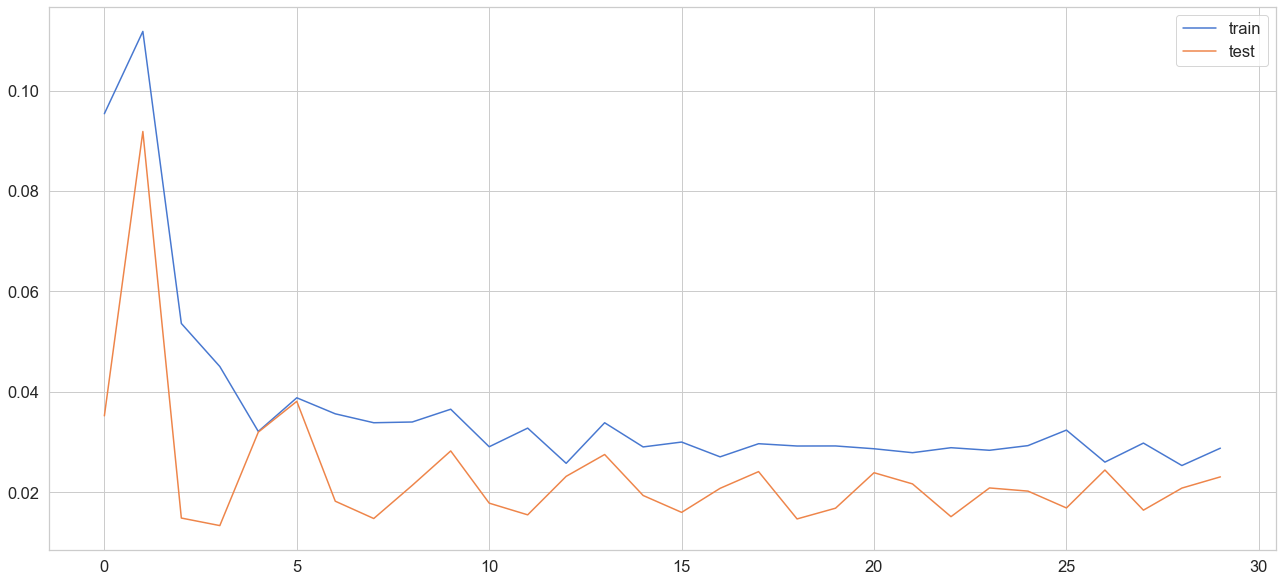

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [13]:
y_predSAAGRU = modelSAAGRU.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invSAAGRU = cnt_transformer.inverse_transform(y_predSAAGRU)

# SA_LSTM With Attention

In [14]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

168 83


In [15]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [16]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(167, 1, 7) (167,)


In [17]:
modelSAA = keras.Sequential()
modelSAA.add(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences = True
    )
)
modelSAA.add(keras.layers.Dropout(rate=0.2))
modelSAA.add(Attention())
modelSAA.add(keras.layers.Dense(units=1))
modelSAA.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
history = modelSAA.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
5/5 [==============================] - 1s 105ms/step - loss: 0.2736 - val_loss: 0.1732
Epoch 2/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.0197
Epoch 3/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.0957
Epoch 4/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0639 - val_loss: 0.0578
Epoch 5/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0354 - val_loss: 0.0156
Epoch 6/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0344 - val_loss: 0.0133
Epoch 7/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 0.0136
Epoch 8/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0298 - val_loss: 0.0214
Epoch 9/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0334 - val_loss: 0.0289
Epoch 10/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 0.0272
Epoch 11/30
5/5 [====================

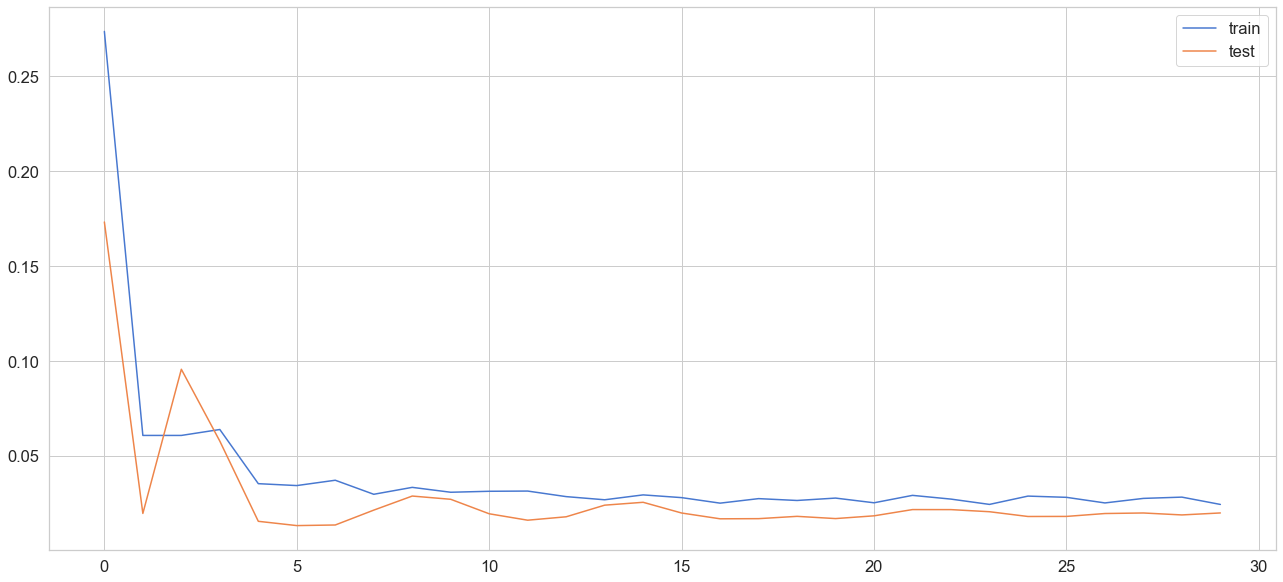

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [20]:
y_predSAA = modelSAA.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invSAA = cnt_transformer.inverse_transform(y_predSAA)

In [21]:
y_pred_invSAA

array([[2715.1562],
       [2720.9988],
       [2732.131 ],
       [2739.9058],
       [2706.3037],
       [2699.8774],
       [2713.993 ],
       [2738.7063],
       [2755.1003],
       [2744.3425],
       [2767.5442],
       [2785.8494],
       [2781.2795],
       [2777.8284],
       [2790.3684],
       [2795.2666],
       [2790.8213],
       [2784.2935],
       [2772.991 ],
       [2794.8557],
       [2799.0112],
       [2786.3362],
       [2771.1091],
       [2736.3784],
       [2741.7275],
       [2770.5637],
       [2788.7947],
       [2802.1404],
       [2804.9392],
       [2789.9497],
       [2823.8337],
       [2831.7456],
       [2819.8977],
       [2840.979 ],
       [2801.1963],
       [2798.3865],
       [2817.092 ],
       [2806.9724],
       [2819.4238],
       [2831.4756],
       [2858.757 ],
       [2866.4958],
       [2866.914 ],
       [2876.7134],
       [2887.869 ],
       [2889.7937],
       [2879.0596],
       [2885.9526],
       [2886.7212],
       [2898.7942],


# SA_LSTM

In [22]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]

train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

168 83


In [23]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [24]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(167, 1, 7) (167,)


In [25]:
modelSA = keras.Sequential()
modelSA.add(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences = False
    )
)
modelSA.add(keras.layers.Dropout(rate=0.2))

modelSA.add(keras.layers.Dense(units=1))
modelSA.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
history = modelSA.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
5/5 [==============================] - 0s 94ms/step - loss: 0.5946 - val_loss: 0.7644
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 0.5075 - val_loss: 0.6487
Epoch 3/30
5/5 [==============================] - 0s 5ms/step - loss: 0.4371 - val_loss: 0.5405
Epoch 4/30
5/5 [==============================] - 0s 5ms/step - loss: 0.3637 - val_loss: 0.4416
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 0.3136 - val_loss: 0.3529
Epoch 6/30
5/5 [==============================] - 0s 5ms/step - loss: 0.2434 - val_loss: 0.2747
Epoch 7/30
5/5 [==============================] - 0s 5ms/step - loss: 0.2049 - val_loss: 0.2073
Epoch 8/30
5/5 [==============================] - 0s 5ms/step - loss: 0.1626 - val_loss: 0.1506
Epoch 9/30
5/5 [==============================] - 0s 5ms/step - loss: 0.1224 - val_loss: 0.1049
Epoch 10/30
5/5 [==============================] - 0s 5ms/step - loss: 0.1013 - val_loss: 0.0702
Epoch 11/30
5/5 [=====================

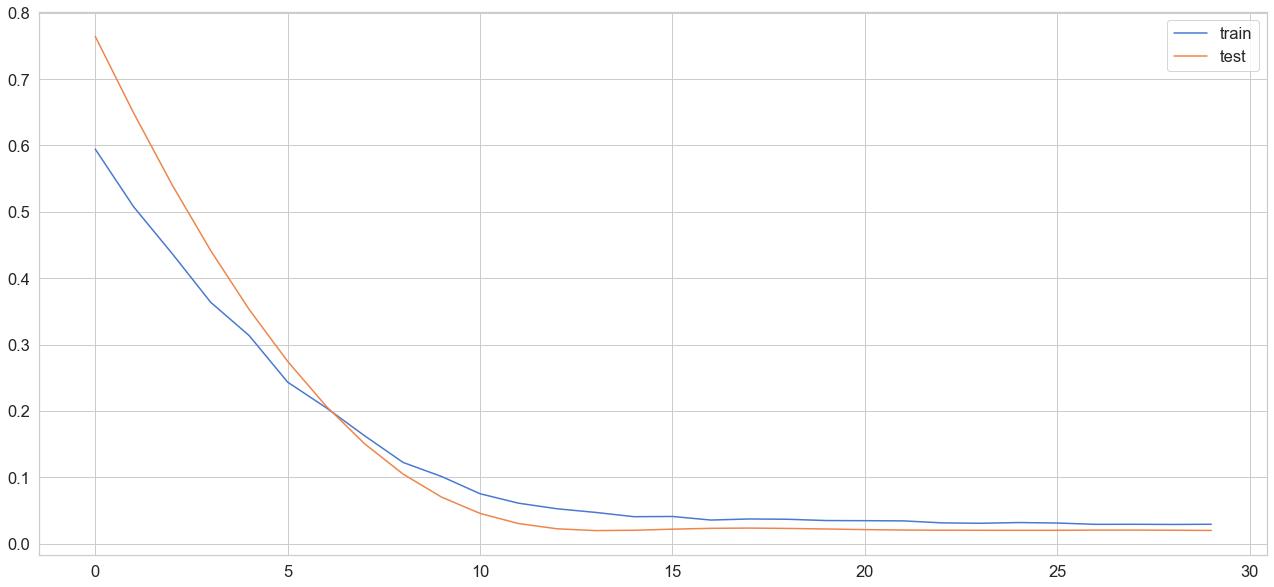

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [28]:
y_predSA = modelSA.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invSA = cnt_transformer.inverse_transform(y_predSA)

# BASELINE LSTM

In [29]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close']]
train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

168 83


In [30]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [31]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(167, 1, 6) (167,)


In [32]:
modelbase = keras.Sequential()
modelbase.add(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
modelbase.add(keras.layers.Dropout(rate=0.2))
modelbase.add(keras.layers.Dense(units=1))
modelbase.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
history = modelbase.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
5/5 [==============================] - 1s 155ms/step - loss: 0.5454 - val_loss: 0.7094
Epoch 2/30
5/5 [==============================] - 0s 5ms/step - loss: 0.4542 - val_loss: 0.5926
Epoch 3/30
5/5 [==============================] - 0s 4ms/step - loss: 0.3901 - val_loss: 0.4850
Epoch 4/30
5/5 [==============================] - 0s 5ms/step - loss: 0.3239 - val_loss: 0.3884
Epoch 5/30
5/5 [==============================] - 0s 5ms/step - loss: 0.2746 - val_loss: 0.3034
Epoch 6/30
5/5 [==============================] - 0s 5ms/step - loss: 0.2215 - val_loss: 0.2300
Epoch 7/30
5/5 [==============================] - 0s 5ms/step - loss: 0.1770 - val_loss: 0.1681
Epoch 8/30
5/5 [==============================] - 0s 7ms/step - loss: 0.1341 - val_loss: 0.1177
Epoch 9/30
5/5 [==============================] - 0s 5ms/step - loss: 0.1054 - val_loss: 0.0784
Epoch 10/30
5/5 [==============================] - 0s 5ms/step - loss: 0.0846 - val_loss: 0.0497
Epoch 11/30
5/5 [====================

In [34]:
y_predbase = modelbase.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invbase = cnt_transformer.inverse_transform(y_predbase)

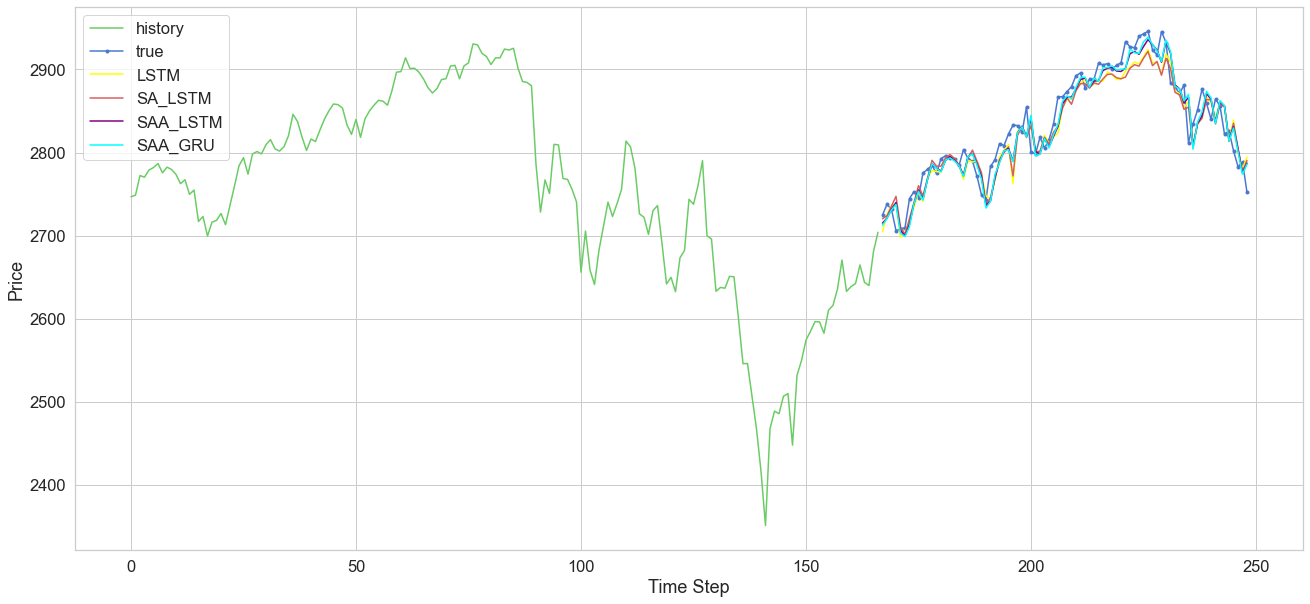

In [36]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invbase.flatten(), 'yellow', label="LSTM")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invSA.flatten(), 'r', label="SA_LSTM")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invSAA.flatten(), 'purple', label="SAA_LSTM")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invSAAGRU.flatten(), 'cyan', label="SAA_GRU")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

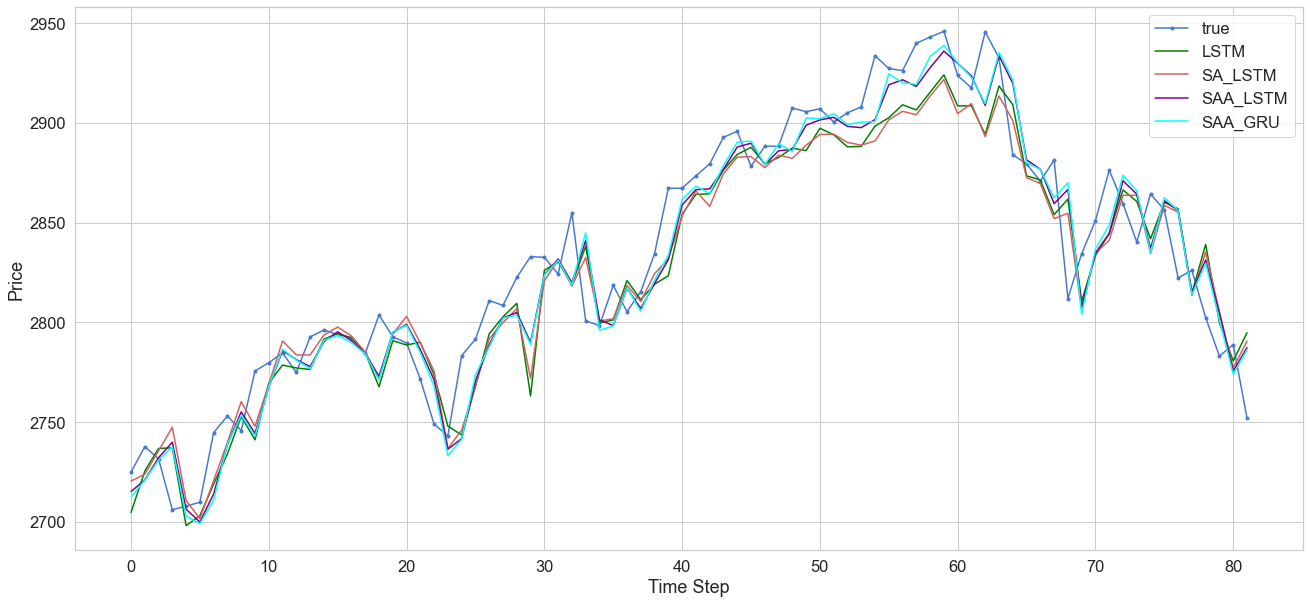

In [37]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_invbase.flatten(), 'green', label = "LSTM")
plt.plot(y_pred_invSA.flatten(), 'r', label="SA_LSTM")
plt.plot(y_pred_invSAA.flatten(), 'purple', label="SAA_LSTM")
plt.plot(y_pred_invSAAGRU.flatten(), 'cyan', label="SAA_GRU")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 

#FOR BASE LSTM

rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invbase.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invbase.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invbase.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invbase.flatten())


print('=======FOR LSTM BASELINE=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

#FOR SA LSTM
rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invSA.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invSA.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invSA.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invSA.flatten())


print('=======FOR SA_LSTM=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

#FOR SAA LSTM
rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invSAA.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invSAA.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invSAA.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invSAA.flatten())


print('=======FOR SAA_LSTM=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

#FOR SAA GRU
rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invSAAGRU.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invSAAGRU.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invSAAGRU.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invSAAGRU.flatten())


print('=======FOR SAA_GRU=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

=======FOR LSTM BASELINE=======

RMSE:  22.528730423821905
MAE:  17.90845917492378
R2:  0.875334584386548
MAPE:  0.6310655596568482
=======FOR SA_LSTM=======

RMSE:  22.26013641030323
MAE:  18.09122820598323
R2:  0.8782894583153364
MAPE:  0.6369340358120524
=======FOR SAA_LSTM=======

RMSE:  20.08802073873373
MAE:  15.849722513338415
R2:  0.9008832966841206
MAPE:  0.5603005951607797
=======FOR SAA_GRU=======

RMSE:  20.24206924594255
MAE:  15.724412871570122
R2:  0.899357280154879
MAPE:  0.5563143366473271
